<a href="https://colab.research.google.com/github/christakahashi/ECE447/blob/master/lectures/discrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE447: Discrete Time Control

Updated by Chris Takahashi 2020

Eric Klavins copyright &copy; 2019, University of Washington

# Init Code

In [0]:
!pip install control

     |████████████████████████████████| 256kB 2.7MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=0b1bb36fea9dc00fe467594584edae36fec34e61c1b43963ae4b04aaec6e030f
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control


In [0]:
import numpy as np
import scipy.integrate as spi
import scipy.linalg as spl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import * 
from control import * 

%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')
 

# Effects of Time Discretization

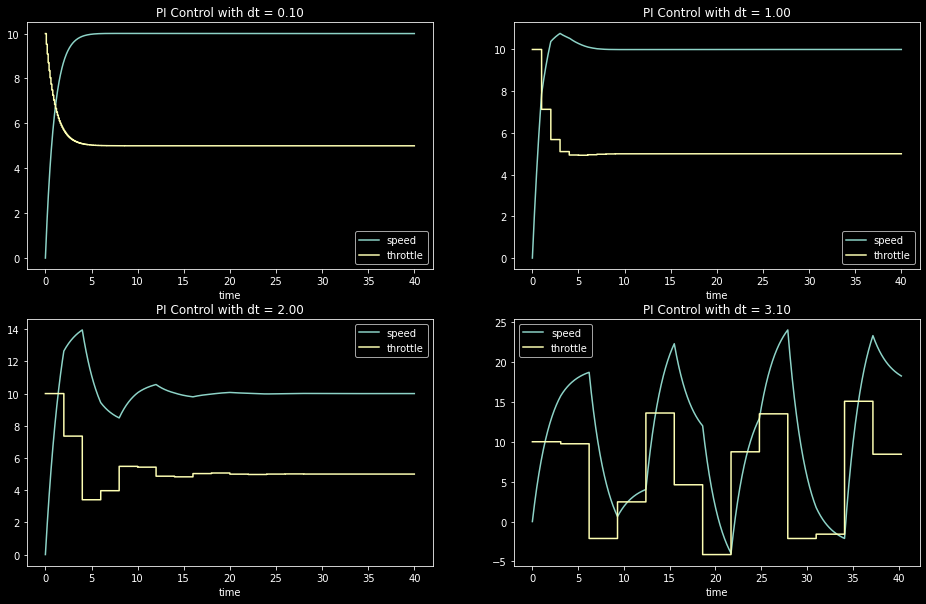

In [0]:
# Simulation parameters
Kp = 1
Ki = 0.5
r = 10
kf = 0.5
  
# Simulation / plotting method
def sim_car(ax,dt) :
       
    # Returns a function for odeint using the given u
    def make_f(u):
        def f(X,t):
            return -kf*X + u
        return f

    # Arrays to store the trajectory
    X = np.array([])
    t = np.array([])
    u = np.array([])

    # Initial state
    T = 0 # Time
    x = 0 # Speed
    z = 0 # Integrator for PI

    # Initial error
    e = r - x


    # Main loop
    while T < 40:
        
        # compute u_i
        control = Kp*e + Ki*z
                
        # compute x_{k+1} and z_{k+1}
        tvals = np.linspace(T,T+dt,40)
        Xnew = spi.odeint(make_f(control),x,tvals)        
        z = z + dt*e
        
        # store trajectory
        t = np.append(t,tvals)        
        X = np.append(X,Xnew)
        u = np.append(u,control*np.ones(40))
        
        # get ready for next iteration
        x = Xnew[-1][0]
        e = r - x
        T = T + dt   
        
    # plot trajectories
    ax.plot(t,X,label="speed");
    ax.step(t,u,label="throttle");
    ax.set_xlabel("time")
    ax.set_title("PI Control with dt = %.2f" % dt)
    ax.legend();        

fig,ax = plt.subplots(2,2,figsize=(16,10)) 

sim_car(ax[0,0], 0.10)
sim_car(ax[0,1], 1.00)
sim_car(ax[1,0], 2.00)
sim_car(ax[1,1], 3.10)

# Discretization of the Example System

In [0]:
var("kf h tau k kp ki dt",real=true,positive=true)
a = exp(-kf*h)
b = integrate(exp(-kf*(h-tau)),(tau,0,h))

Ad = Matrix([
    [a-b*kp, b*ki],
    [-h,1]
])
Bd = Matrix([
    [b*kp],
    [h]
])

params = [(kp,1), (ki,0.5), (kf,0.5), (h,3.1)]
Ad.subs(params), [N(abs(e)) for e in Ad.subs(params).eigenvals()]

⎛⎡-1.36325607851977  0.787752026173257⎤                                      ⎞
⎜⎢                                    ⎥, [1.03864103645934, 1.03864103645934]⎟
⎝⎣      -3.1                 1        ⎦                                      ⎠

In [0]:
x0 = Matrix([[0],[0]])
x1 = (Ad*x0 + Bd*10).subs(params)
x2 = (Ad*x1 + Bd*10).subs(params)
x0, x1, x2

⎛⎡0⎤  ⎡15.7550405234651⎤  ⎡18.6971985738969⎤⎞
⎜⎢ ⎥, ⎢                ⎥, ⎢                ⎥⎟
⎝⎣0⎦  ⎣      31.0      ⎦  ⎣13.1593743772581⎦⎠

In [0]:
u0 = (kp*(10-x0[0]) + ki*x0[1]).subs(params)
u1 = (kp*(10-x1[0]) + ki*x1[1]).subs(params)
u2 = (kp*(10-x2[0]) + ki*x2[1]).subs(params)
u0,u1,u2

(10, 9.74495947653486, -2.11751138526791)

In [0]:
x0[0]

0

In [0]:
eig = lambdify(dt,
               Ad.subs(h,dt).subs(params).tolist(),
               'numpy')

In [0]:
Ad.subs(h,1)

⎡     ⎛      -kf⎞            ⎛      -kf⎞⎤
⎢     ⎜1    ℯ   ⎟    -kf     ⎜1    ℯ   ⎟⎥
⎢- kp⋅⎜── - ────⎟ + ℯ     ki⋅⎜── - ────⎟⎥
⎢     ⎝kf    kf ⎠            ⎝kf    kf ⎠⎥
⎢                                       ⎥
⎣          -1                   1       ⎦

In [0]:

def evs(dt):
    M = Ad.subs(h,dt).subs(params)
    lam,v = np.linalg.eig(np.array(M.tolist()).astype(np.float64))
    return lam

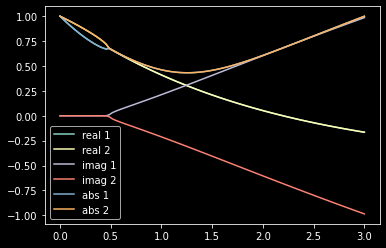

In [0]:
hvals = np.linspace(0,3,100)
y = np.array([evs(H) for H in hvals])
plt.plot(hvals,np.real(y[:,0]),label="real 1");
plt.plot(hvals,np.real(y[:,1]),label="real 2");
plt.plot(hvals,np.imag(y[:,0]),label="imag 1");
plt.plot(hvals,np.imag(y[:,1]),label="imag 2");
plt.plot(hvals,np.abs(y[:,0]),label="abs 1");
plt.plot(hvals,np.abs(y[:,1]),label="abs 2");
plt.legend()

# Discretization in General

More generally, suppose we have a system like

\begin{align}
\dot {\bf x} & = A {\bf x} + B u \\
y & = C {\bf x}
\end{align}

Then 

# Trajectories

In [0]:
def trajectory(A,B,C,u,x0):
    """Simulate the discrete system x(k+1) = Ax(k) + Bu(k), y(k) = Cx(k)
       starting at x0 for len(u) steps.
    """
    i = 0
    x = x0    
    y = [np.matmul(C,x0)]
    while i < len(u):
        x = np.matmul(A,x) + B*u[i]
        y = np.append(y,np.matmul(C,x))
        i = i + 1
    return y        

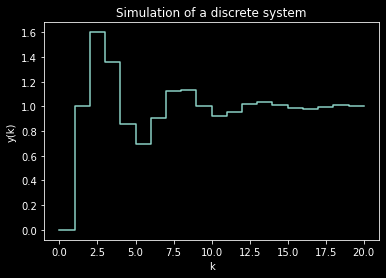

In [0]:
#
# We will use the following A, B, and C matrices as a running example.
# 
A = np.array([
    [1,-1],
    [1,-4/10]
])
B = np.array([
    [1],
    [0]
])
C = np.array([[0,1]])
x0 = np.array([
    [0],
    [0]
])
u = np.ones(20);
t = np.linspace(0,20,21)
ysim = trajectory(A,B,C,u,x0)
plt.step(t,ysim)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Simulation of a discrete system");

# Solutions

Say 

\begin{align}
{\bf x}_{k+1} & = A {\bf x}_k + B u_k  \\
y & = C {\bf x}_k
\end{align}

Assuming we know ${\bf x}_0$, we have

\begin{align}
{\bf x}_1 & = A {\bf x}_0 + B u_0 \\
          & \\
{\bf x}_2 & = A {\bf x}_1 + B u_1 \\
          & = A (A {\bf x}_0 + B u_0) + B u_1\\
          & = A^2 {\bf x}_0 + A B u_0 + B u_1 \\
          & \\
{\bf x}_3 & = A {\bf x}_2 + B u_2 \\
          & = A (A^2 {\bf x}_0 + A B u_0 + B u_1) + B u_2\\
          & = A^3 {\bf x}_0 + A^2 B u_0 + A B u_1 + B u_2
\end{align}

Generally, we have

\begin{align}
{\bf x}_{k} & = A^k {\bf x}_0 + \sum_{i=0}^k A^{k-i-1} B u_i,
\end{align}

which is the sum of the *natural* and *forced* responses. As usual, the output is

$$
y_k = C {\bf x}_k.
$$

In [0]:
def solution(A,B,C,u,x0):
    k = len(u)
    if k == 0:
        return np.matmul(C,x0)[0]
    else:
        x = np.matmul(np.linalg
                      .matrix_power(A,k),x0) + sum([
              np.matmul(np.linalg.matrix_power(A,k-i-1),B)*u[i] for i in range(k)
            ])
        return np.matmul(C,x)[0,0]

def step_response(A,B,C,n,mag=1):
    # Note, this is a pretty innefficient way to compute a response. The
    # simulation above is just as accurate, but much faster.
    t = np.linspace(0,n,n+1)
    x0 = np.zeros(len(B))
    y = np.array([solution(A,B,C,mag*np.ones(k),x0) for k in range(n+1)])
    return (t,y)

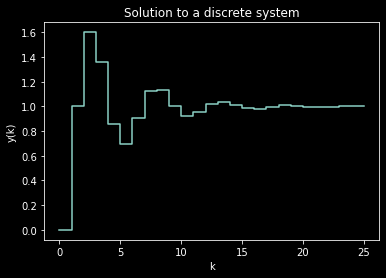

In [0]:
t,y = step_response(A,B,C,25)
plt.step(t,y)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Solution to a discrete system");

# Stability of Discrete Systems

Just as in continuous systems, the natural response of a discrete system determines its stability. To understand the natural response, first suppose that $A$ is diagonalizable. Then

$$
A = P D P^{-1}
$$

for some $P$ where $D$ is the matrix of eigenvalues

$$
D = \begin{pmatrix}
\lambda _1 &           &        & \\
           & \lambda_2 &        & \\
           &           & \ddots & \\
           &           &        & \lambda_n
\end{pmatrix}
$$

Then

\begin{align}
A^k & = (PDP^{-1})^k \\
    & = PDP^{-1}PDP^{-1} \dots PDP^{-1} \\
    & = P D^k PDP^{-1}
\end{align}

and since

$$
D^k = \begin{pmatrix}
\lambda _1^k &           &        & \\
           & \lambda_2^k &        & \\
           &           & \ddots & \\
           &           &        & \lambda_n^k
\end{pmatrix}
$$

we just need that $\lambda_i^k \rightarrow 0$ as $k \rightarrow \infty$. This happens as long as 

$$
|\lambda_i| < 1
$$

for all $i$.

If $A$ is not diagonalizable, it can be put in Jordan form. It can also be shown that Jordan blocks are stable under iteration when they correspond to eigenvalues inside the unit circle. 

Therefore, for $A$ to define a stable discrete linear system then, we require that

> All the eigenvalues of $A$ lie in the unit circle.

In [0]:
# The running example is stable
lam, v = np.linalg.eig(A)
lam, np.abs(lam)

(array([0.3+0.71414284j, 0.3-0.71414284j]), array([0.77459667, 0.77459667]))

In [0]:
# Example of an unstable A
Au = np.array([
    [1, -1],
    [1, 0.4]
])
lam, v = np.linalg.eig(Au)
lam, np.abs(lam)

(array([0.7+0.9539392j, 0.7-0.9539392j]), array([1.18321596, 1.18321596]))

Note that when the eigenvalues of $A$ are inside the unit circle, then

$$
\sum_{i=0}^k A^{k-i-1} B u_i
$$

converges to the final value of system, assuming $u$ converges. For a step input, $u_i=1$, we get

$$
\mathrm{y_\infty} = \lim_{k \rightarrow \infty} \sum_{i=0}^k A^{k-i-1} B
$$

In the case the $A$ is diagonalizable as $PDP^{-1}$, we get

\begin{align}
\mathrm{y_\infty} & = \lim_{k \rightarrow \infty} (A^{k-1} + ... + A^0 ) B \\
                  & = \lim_{k \rightarrow \infty} (PD^{k-1}P^{-1} + ... + PD^0P^{-1}) B \\
                  & = \lim_{k \rightarrow \infty} P(D^{k-1} + ... + D^0 )P^{-1} B \\
                  & = P D^\infty P^{-1} B
\end{align}

To evaluate $D^\infty$ we note that each eigenvalue $\lambda$ along the diagonal in $D$ goes to the geometric progression

$$
\sum_{i=0}^\infty \lambda^i = \frac{1}{1-\lambda}
$$

which exists since $|\lambda_i| < 0$. 

A similar argument applies when $A$ is not diagonalizaable, but can be put into Jordan form.

In [0]:
# Example final value calculation
Asym = Matrix(A)
Bsym = Matrix(B)
Csym = Matrix(C)
P,D = Asym.diagonalize()
P,D

⎛⎡0.7 - 0.714142842854285⋅ⅈ  0.7 + 0.714142842854285⋅ⅈ⎤  ⎡0.3 - 0.714142842854
⎜⎢                                                    ⎥, ⎢                    
⎝⎣           1.0                        1.0           ⎦  ⎣            0       

285⋅ⅈ              0            ⎤⎞
                                ⎥⎟
       0.3 + 0.714142842854285⋅ⅈ⎦⎠

In [0]:
Dinf = Matrix([
    [1/(1-D[0,0]),0],
    [0, 1/(1-D[1,1])]
])
Dinf

⎡1.0⋅(0.7 - 0.714142842854285⋅ⅈ)                 0               ⎤
⎢                                                                ⎥
⎣               0                 1.0⋅(0.7 + 0.714142842854285⋅ⅈ)⎦

In [0]:
(Csym*(P*Dinf*P.inv()).evalf(chop=True)*Bsym)[0]

1.00000000000000

# Final Value

For a discrete system, an equilibrium is obtained when ${\bf x}$ stops changing. That means that an equilibrium solves

\begin{align}
{\bf x} & = A {\bf x} + B u \\
(I-A) {\bf x} & = B u \\
{\bf x} & = (I-A)^{-1} B u
\end{align}

assuming $(I-A)$ is invertible and $A$ is discrete-time stable. If not, then the final value depends on the initial condition.


In [0]:
C*(eye(2)-A).inv()*B

[1.0]

# Full State Feedback

For the system

\begin{align}
{\bf x}_{k+1} & = A {\bf x}_k + B u_k  \\
y & = C {\bf x}_k
\end{align}

we define the controller

$$
u_k = -K {\bf x}_k + r_k
$$

where $K$ is a $1 \times n$ matrix of gains and $r_k$ is the new input to the system. In this case,

\begin{align}
{\bf x}_{k+1} & = A {\bf x}_k + B (-K {\bf x}_k + r_k) \\
              & = (A-BK){\bf x}_k + B r_k
\end{align}

The design goal is then to choose $K$ so that the poles of $(A-BK)$ are inside the unit circle and also give the desired performance.

In [0]:
K = place(A,B,[0.2 + 0.1*1j,0.2-0.1*1j])
K

matrix([[ 0.2 , -0.63]])

In [0]:
sigma = np.matmul(np.matmul(C,np.linalg.inv(np.identity(2) - A+np.matmul(B,K))),B)[0,0]
sigma

1.5384615384615388

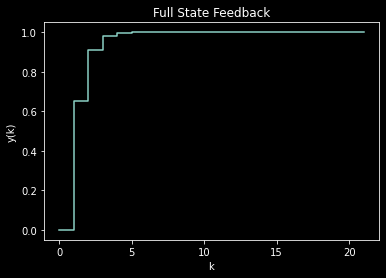

In [0]:
t,y = step_response(A-np.matmul(B,K),B,C,21,1/sigma)
plt.step(t,y)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Full State Feedback");

Bang-Bang Control
---

One thing we cannot do in continuous control systems is put poles at zero, since those would be unstable. In discrete systems, we can put *all* the poles at zero. To see what happens in this case, we need the following theorem:

> **Caley-Hamilton Theorem**: A matrix solves its own characteristic polynomial.

For example:

In [0]:
var("s")
cp = (s*eye(2)-Asym).det()
cp

(s - 1.0)⋅(s + 0.4) + 1.0

In [0]:
Asym**2 - 0.6*Asym + 0.6*eye(2)

⎡         0            -1.11022302462516e-16⎤
⎢                                           ⎥
⎣1.11022302462516e-16  1.11022302462516e-16 ⎦

In the case of bang-bang control, we put all the poles at zero, so the characteristic polynomial of $A-BK$ is $s^n$. That means, that 

$$
A^n = 0
$$

so after $n$ steps, the system will have stabilized.

One problem is that our normal way of placing poles, using the `place` command, does not work for repeated poles. However, another method of placing poles, using Ackerman's method, works just fine.

Ackerman's method uses the Caley-Hamilton theorem to show that

$$
K = \begin{pmatrix}
  0 & \dots & 0 & 1
\end{pmatrix} \mathcal{C}^{-1} \mathrm{p}(A)
$$

where $\mathcal{C}$ is the controllability matrix for $A$ and $\mathrm{p}(A)$ is the *desired* characteristic polynomial evaluated at $A$

Our running example should be stabilizable after 2 steps.

In [0]:
Kbb = acker(A,B,[0,0])
Kbb

matrix([[ 0.6 , -0.84]])

In [0]:
sigma = np.matmul(np.matmul(C,np.linalg.inv(np.identity(2) - A+np.matmul(B,Kbb))),B)[0,0]
sigma

1.0

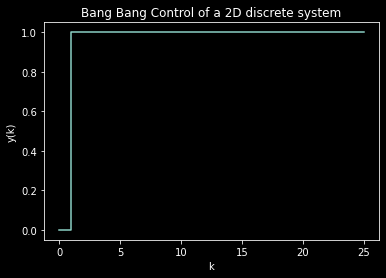

In [0]:
t,y = step_response(A-np.matmul(B,Kbb),B,C,25,1/sigma)
plt.step(t,y)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Bang Bang Control of a 2D discrete system");

In [0]:
# Bigger Example
Abig = 2*np.random.rand(5,5) - np.ones((5,5))
Bbig = np.random.rand(5,1) - 0.5*np.ones((5,1))
Cbig = np.random.rand(1,5) - 0.5*np.ones((1,5))
lam,v = np.linalg.eig(Abig)
abs(lam)

array([1.2025315 , 1.22271909, 0.62043342, 0.51178275, 0.51178275])

In [0]:
Kbig = acker(Abig,Bbig,[0,0,0,0,0])
Kbig

matrix([[ 1.7621199 ,  2.6015667 , 13.07940517, -0.99107769, 10.46388631]])

In [0]:
sigma = np.matmul(np.matmul(Cbig,np.linalg.inv(np.identity(5) - Abig+np.matmul(Bbig,Kbig))),Bbig)[0,0]
sigma

0.02215618441902533

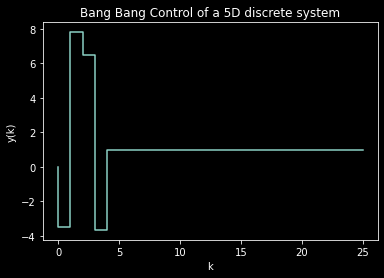

In [0]:
t,y = step_response(Abig-np.matmul(Bbig,Kbig),Bbig,Cbig,25,mag=1/sigma)
plt.step(t,y)
plt.xlabel("k")
plt.ylabel("y(k)")
plt.title("Bang Bang Control of a 5D discrete system");

Bang-bang control is great mathematically, and is used in some applications as well. However

- It may require large forces (or sudden current changes)
- It is sensitive to delays, which cause oscillations
- It can be sensitive to uncertainty in $A$

Thus, it can often be better to use non-zero poles instead of all zeros.

# Observer Design

Observer design is similar to the continuous case. We define 

\begin{align}
\hat{\bf x}_{k+1} & = A \hat{\bf x}_k + B u_k + L(y_k-C\hat {\bf x}) \\
                  & = (A-LC) \hat{\bf x} + B u_k + L y_k
\end{align}

The goal is then to choose $L$ to set the poles of $A-LC$ inside the unit circle. Choosing the poles to be half as big in magnitude as the system's poles and with small imaginary parts is a good guide.